# 04_evaluation_and_comparison.ipynb
# 1- Configuration & Imports

In [14]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast, pipeline

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils.visualization_utils import plot_model_comparison_barplot, plot_confusion_matrix
from src.utils.evaluation_utils import load_predictions, load_classification_report

# 2 - Chargement des scores de modèles

In [15]:
results_path = "../results/model_scores_logreg_vs_distilbert_vs_electra.csv"
df_scores = pd.read_csv(results_path)
df_scores

,Modèle,Accuracy,F1-score
0,TF-IDF + LogReg,0.780350,0.783201
1,DistilBERT fine-tuné,0.814500,0.819640
2,ELECTRA,0.821577,0.818834


# 3 - Graphique comparatif des F1-score et Accuracy

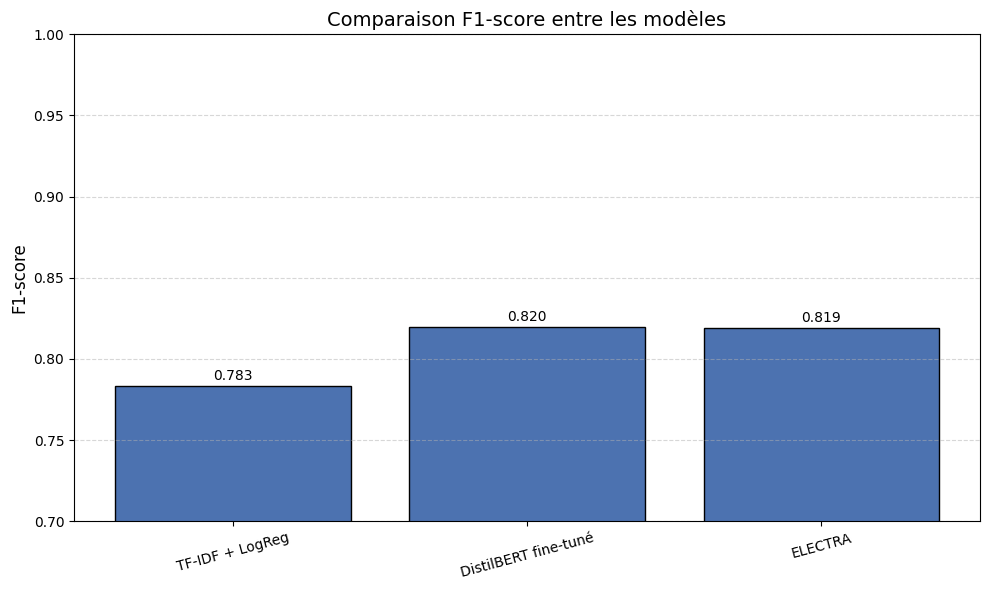

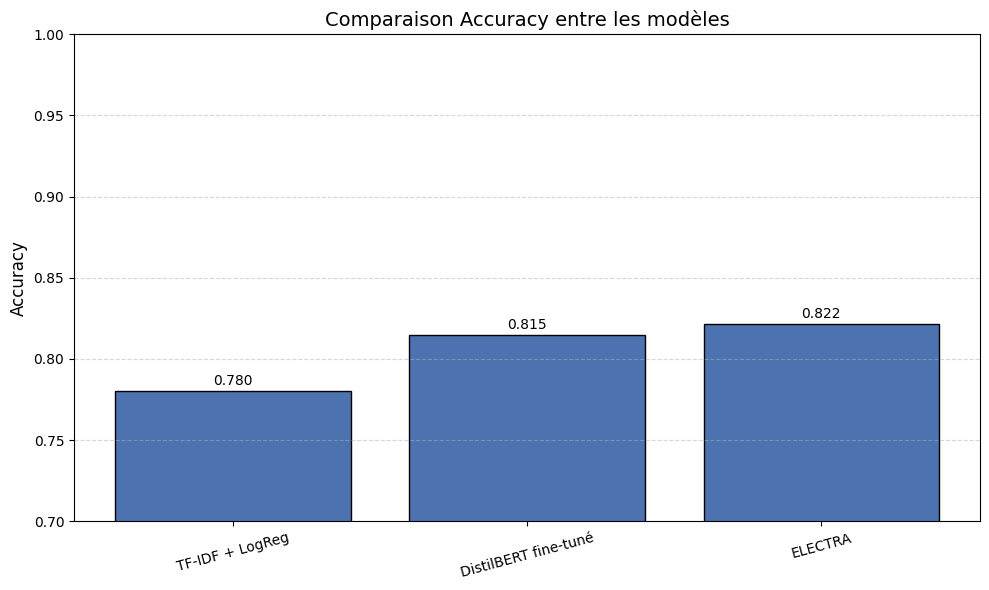

In [16]:
plot_model_comparison_barplot(
    df = df_scores,
    metric_col = "F1-score",
    title = "Comparaison F1-score entre les modèles",
    save_path = "../results/comparaison_f1.png"
)

plot_model_comparison_barplot(
    df = df_scores,
    metric_col = "Accuracy",
    title = "Comparaison Accuracy entre les modèles",
    save_path = "../results/comparaison_accuracy.png"
)

# 4 - Matrices de confusion
## 4.1 - Prédictions ELECTRA

In [17]:
df_preds_electra = pd.read_csv("../results/electra_predictions_sample.csv")

## 4.2 - Matrice de confusion ELECTRA

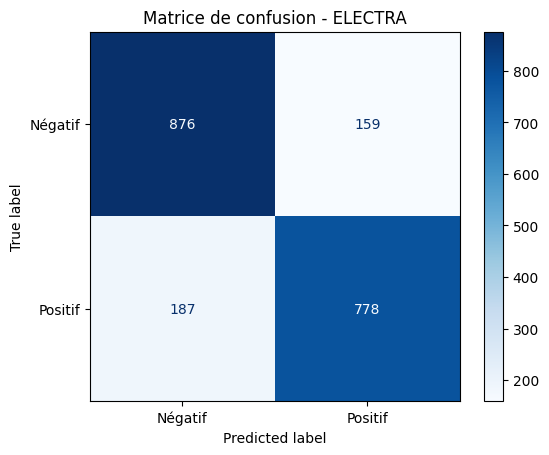

In [18]:
plot_confusion_matrix(
    y_true = df_preds_electra["label"],
    y_pred = df_preds_electra["prediction"],
    labels = ["Négatif", "Positif"],
    title = "Matrice de confusion - ELECTRA",
    save_path = "../results/cm_electra.png"
)

# 5 - Interprétabilité locale (optionnelle)

In [25]:
# Optionnel : à activer uniquement si souhaité
from lime.lime_text import LimeTextExplainer
from transformers import pipeline
import os
import numpy as np

model_dir = "../models/electra_model"  # Chemin local ABSOLU ou RELATIF

print("Contenu du dossier modèle :", os.listdir(model_dir))

# Chargement du modèle et tokenizer
model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = model_dir,
    local_files_only = True
)

tokenizer = ElectraTokenizerFast.from_pretrained(
    pretrained_model_name_or_path = model_dir,
    local_files_only = True
)

# Chargement du modèle ELECTRA pour inférence
pipe = pipeline("text-classification", model = model, tokenizer = tokenizer, return_all_scores = True)

def classifier_fn_lime(texts):
    preds = pipe(texts)
    return np.array([[p[0]['score'], p[1]['score']] for p in preds])

# LIME
explainer = LimeTextExplainer(class_names = ["Négatif", "Positif"])
tweet_example = df_preds_electra["text"].iloc[0]

explanation = explainer.explain_instance(tweet_example, classifier_fn_lime, num_features = 8)
explanation.show_in_notebook(text = tweet_example)

Contenu du dossier modèle : ['config.json', 'model.safetensors', 'pytorch_model.bin', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'training_args.bin', 'vocab.txt']


## Synthèse comparative

- **TF-IDF + LogReg** : modèle très léger, bon compromis pour un usage CPU pur.
- **DistilBERT** : meilleure performance brute mais trop lourd pour le déploiement.
- **ELECTRA** : excellent compromis entre performances et poids modèle.

## Limites et améliorations

- Faible interprétabilité des modèles Transformers
- Potentiel de compression (pruning / quantization)
- Enrichissement du dataset ou fine-tuning sur un domaine spécifique